<a href="https://colab.research.google.com/github/SJinji/tag-recommendation-system-with-last.fm-dataset/blob/main/3_Tag_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud

In [ ]:
!pip install transformers

In [28]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader


# Download the NLTK tokenizer resource
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Data Loading**

In [ ]:
! unzip /content/deezer-tech-test-DS-internship.zip

In [5]:
# Load the data
artists = pd.read_csv('deezer-business-case/data/artists.dat',sep="\t")
tags = pd.read_csv('deezer-business-case/data/tags.dat',encoding="gbk",sep="\t")
user_artists = pd.read_csv('deezer-business-case/data/user_artists.dat',sep="\t")
user_friends = pd.read_csv('deezer-business-case/data/user_friends.dat',sep='\t')
tag_artists = pd.read_csv('deezer-business-case/data/user_taggedartists.dat',sep='\t')

# Merge data to create m_tag_artists DataFrame
m_tag_artists = pd.merge(tag_artists, tags, on="tagID", how="left")

**User Defined Function**

In [15]:
# Preprocess tags
def preprocess_tags(tags):
    # Lowercase and tokenize tags
    tags = [tag.lower() for tag in word_tokenize(tags)]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tags = [tag for tag in tags if tag not in stop_words]

    # Remove special characters like '-' and '
    tags = [tag.replace('-', '').replace("'", '') for tag in tags]

    # Remove tags with only one character
    tags = [tag for tag in tags if len(tag) > 1]

    # Remove the 'none' tag
    tags = [tag for tag in tags if tag != 'none']

    return " ".join(tags)

In [16]:
# Evaluate the recommendation system using hold-out evaluation
def hold_out_evaluation(tag_data, word2vec_model, normalized_tag_embeddings, test_frac, top_n):

    test_frac=0.2

    num_users = len(tag_data['artistID'])
    num_test_users = int(num_users * test_frac)

    precision_scores = []
    recall_scores = []
    f1_scores = []

    for i in range(num_test_users):
        # Randomly select a user for testing
        test_user_idx = np.random.randint(0, num_users)
        test_user_tags = tag_data.iloc[test_user_idx]['tagValue'].split()

        # Get the recommended tags for the test user
        recommended_tags = get_tag_recommendations(test_user_tags, word2vec_model, normalized_tag_embeddings, top_n=top_n)

        if recommended_tags is not None:
            # Evaluate the recommended tags against the ground truth (left-out tags)
            true_tags_set = set(test_user_tags)
            recommended_tags_set = set(recommended_tags)

            # Calculate precision, recall, and F1-score
            precision = len(true_tags_set.intersection(recommended_tags_set)) / len(recommended_tags_set)
            recall = len(true_tags_set.intersection(recommended_tags_set)) / len(true_tags_set)

            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0.0

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

    # Calculate average precision, recall, and F1-score
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_precision, avg_recall, avg_f1

**WordCloud of Tags**

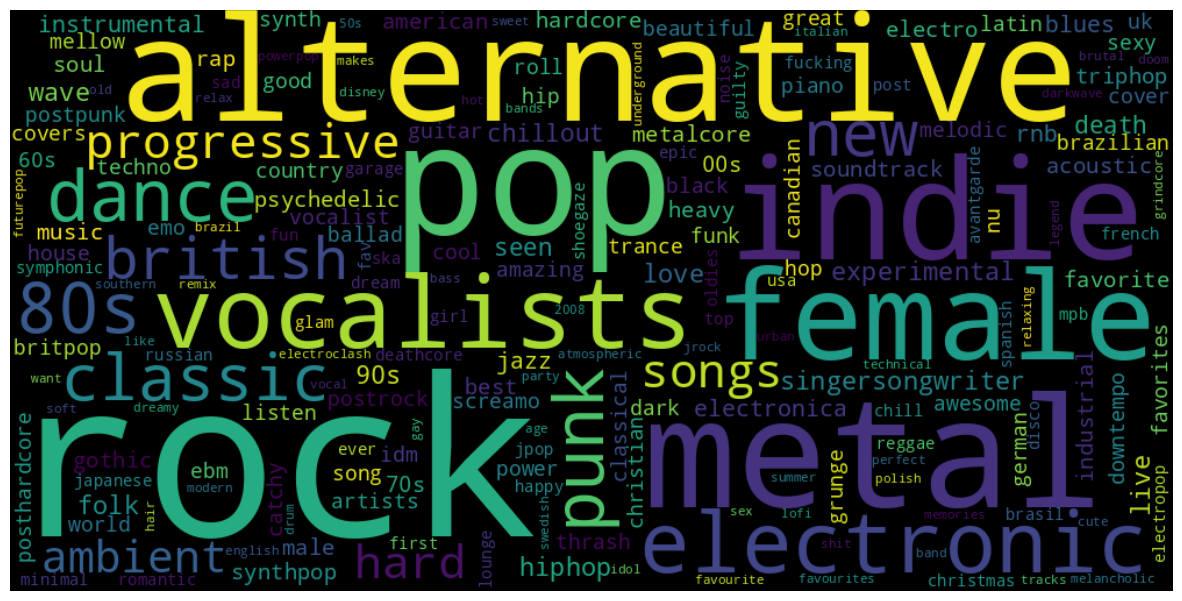

In [17]:
tag_data = m_tag_artists.groupby('artistID')['tagValue'].apply(lambda x: " ".join(x)).reset_index()
tag_data['tagValue'] = tag_data['tagValue'].apply(preprocess_tags)

tag_counts = tag_data['tagValue'].str.split().explode().value_counts()

# Convert tag_counts to a dictionary
tag_counts_dict = tag_counts.to_dict()

# Create a WordCloud object
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(tag_counts_dict)

# Display the WordCloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Word2Vec (Best Model)

In [21]:
def train_word2vec(tag_data):
    sentences = [tags.split() for tags in tag_data['tagValue']]
    model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)
    return model

def get_tag_embeddings(word2vec_model):
    tag_embeddings = np.array([word2vec_model.wv[tag] for tag in word2vec_model.wv.index_to_key])
    normalized_tag_embeddings = normalize(tag_embeddings)
    return normalized_tag_embeddings

def calculate_similarity_matrix(embeddings):
    return cosine_similarity(embeddings)

def get_tag_recommendations(tags, word2vec_model, normalized_tag_embeddings, top_n):
    # Get embeddings for input tags
    input_tag_embeddings = np.array([word2vec_model.wv[tag] for tag in tags if tag in word2vec_model.wv])

    if len(input_tag_embeddings) == 0:
        return None

    # Normalize input tag embeddings
    normalized_input_tag_embeddings = normalize(input_tag_embeddings)

    # Calculate cosine similarity between input tags and all tags
    similarities = cosine_similarity(normalized_input_tag_embeddings, normalized_tag_embeddings)

    # Get top N similar tags based on the mean similarity score for each input tag
    mean_similarities = np.mean(similarities, axis=0)
    recommended_tag_indices = np.argsort(mean_similarities)[::-1]

    # Get recommended tags
    recommended_tags = [word2vec_model.wv.index_to_key[idx] for idx in recommended_tag_indices][:top_n]

    return recommended_tags

# For the evaluation of performance
def plot_random_similarity_heatmap(tag_sim_matrix, word2vec_model, num_tags=20):
    # Get random indices of tags
    indices = np.random.choice(len(tag_sim_matrix), size=num_tags, replace=False)

    # Create subset matrix
    subset_matrix = tag_sim_matrix[np.ix_(indices, indices)]

    # Get the corresponding tag names
    selected_tags = [word2vec_model.wv.index_to_key[idx] for idx in indices]

    # Plot the heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(subset_matrix, annot=True, cmap="YlGnBu", xticklabels=selected_tags, yticklabels=selected_tags)
    plt.title("Tag Similarity Heatmap for Randomly Selected Tags")
    plt.show()

def plot_similarity_heatmap(tag_data, word2vec_model, normalized_tag_embeddings, user_idx, top_n):
    user_tags = tag_data.iloc[user_idx]['tagValue'].split()
    recommended_tags = get_tag_recommendations(user_tags, word2vec_model, normalized_tag_embeddings, top_n=top_n)

    similarities = cosine_similarity([word2vec_model.wv[tag] for tag in user_tags],
                                     [word2vec_model.wv[tag] for tag in recommended_tags])

    sns.heatmap(similarities, annot=True, xticklabels=recommended_tags, yticklabels=user_tags)
    plt.xlabel('Recommended Tags')
    plt.ylabel('True Tags')
    plt.show()

def plot_ranked_positions(tag_data, word2vec_model, normalized_tag_embeddings, test_frac, top_n):

    test_frac=0.2

    num_users = len(tag_data['artistID'])
    test_user_indices = np.random.choice(num_users, int(num_users * test_frac), replace=False)

    ranked_positions = []

    for test_user_idx in test_user_indices:
        test_user_tags = tag_data.iloc[test_user_idx]['tagValue'].split()
        recommended_tags = get_tag_recommendations(test_user_tags, word2vec_model, normalized_tag_embeddings, top_n=top_n)

        for true_tag in test_user_tags:
            if true_tag in recommended_tags:
                ranked_positions.append(recommended_tags.index(true_tag))

    plt.hist(ranked_positions, bins=range(1, top_n+1), edgecolor='black')
    plt.xlabel('Ranked Position')
    plt.ylabel('Frequency')
    plt.title('Histogram of Ranked Positions of True Tags')
    plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 37494 (\N{CJK UNIFIED IDEOGRAPH-9276}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37494 (\N{CJK UNIFIED IDEOGRAPH-9276}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


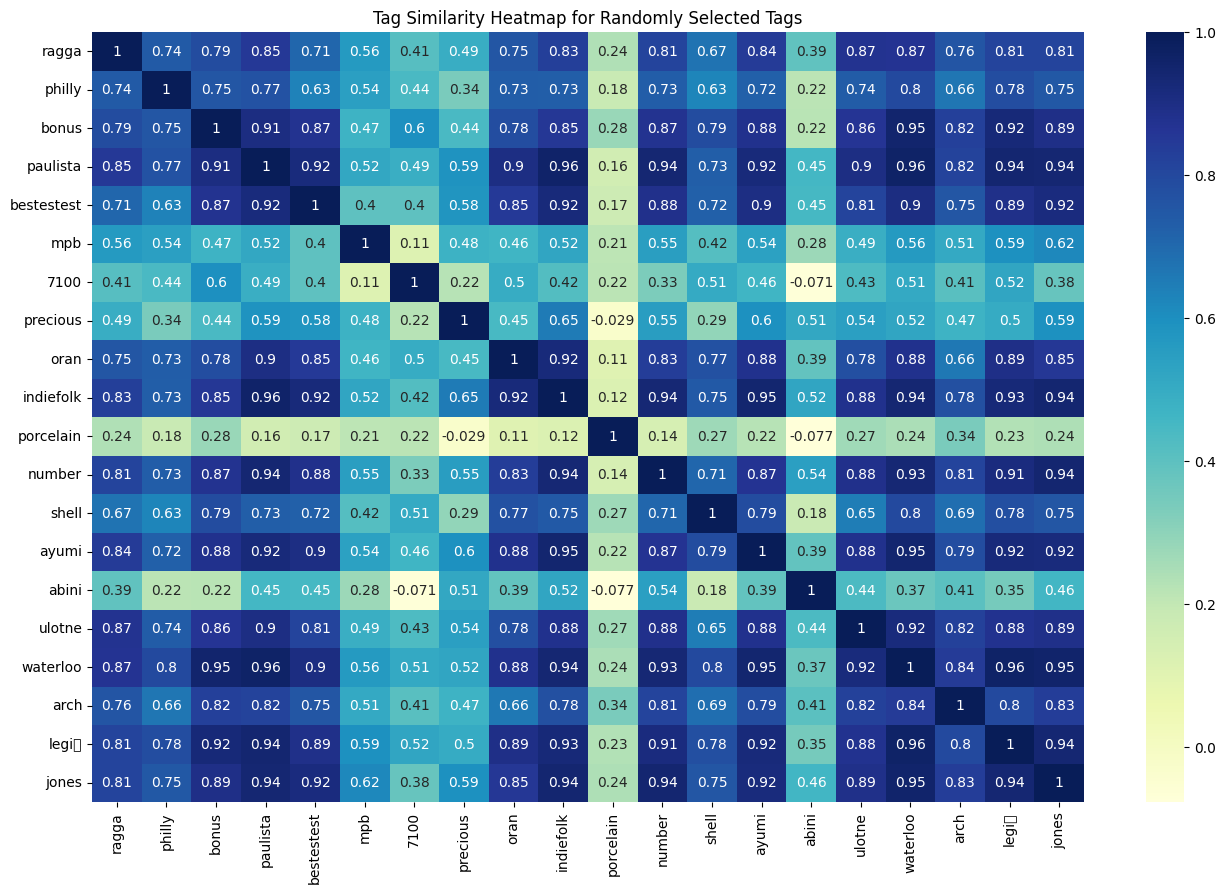

Recommended Tags: ['poprock', 'soft', 'australian', 'british', 'scottish']
Average Precision: 0.2603161919981736
Average Recall: 0.4115230948049661
Average F1-score: 0.2665889686682104


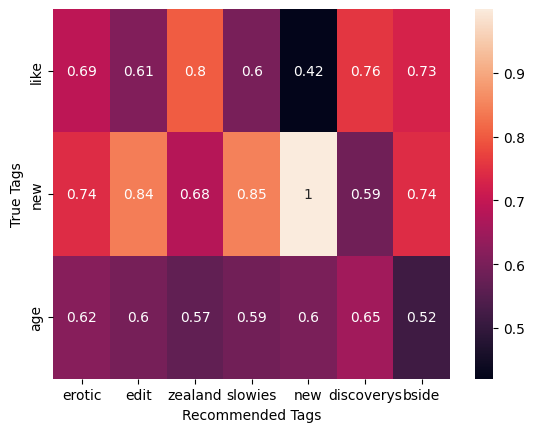

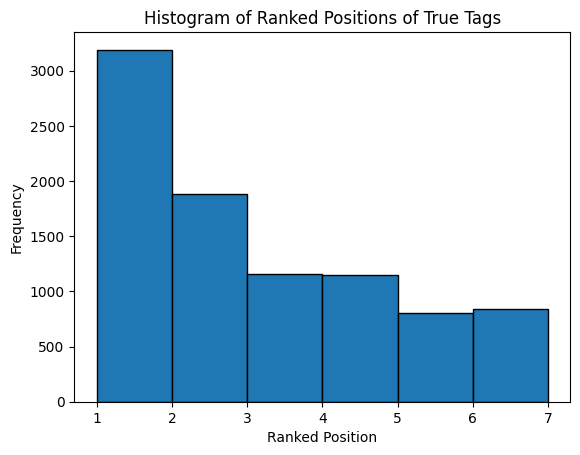

In [22]:
def main():
    # Preprocess the data and create tag embeddings
    tag_data = m_tag_artists.groupby('artistID')['tagValue'].apply(lambda x: " ".join(x)).reset_index()
    tag_data['tagValue'] = tag_data['tagValue'].apply(preprocess_tags)

    # Train Word2Vec model
    word2vec_model = train_word2vec(tag_data)

    # Get the embeddings and normalize them
    normalized_tag_embeddings = get_tag_embeddings(word2vec_model)

    # Calculate tag similarity matrix using cosine similarity
    tag_sim_matrix = calculate_similarity_matrix(normalized_tag_embeddings)

    # Plot the heatmap
    plot_random_similarity_heatmap(tag_sim_matrix, word2vec_model, num_tags=20)

    # Example of using get_tag_recommendations
    tags = ["rock", "pop"]
    recommended_tags = get_tag_recommendations(tags, word2vec_model, normalized_tag_embeddings, top_n=7)
    print("Recommended Tags:", recommended_tags[2::])

    # Perform the evaluation
    avg_precision, avg_recall, avg_f1 = hold_out_evaluation(tag_data, word2vec_model, normalized_tag_embeddings, test_frac=0.2, top_n=7)

    print("Average Precision:", avg_precision)
    print("Average Recall:", avg_recall)
    print("Average F1-score:", avg_f1)

    # Randomly select a user index
    random_user_idx = np.random.randint(0, len(tag_data['artistID']))

    # Call the function with the random user index
    plot_similarity_heatmap(tag_data, word2vec_model, normalized_tag_embeddings, random_user_idx, top_n=7)
    plot_ranked_positions(tag_data, word2vec_model, normalized_tag_embeddings, test_frac=0.2, top_n=7)

if __name__ == "__main__":
    main()


### Hyperparameter Tuning

In [23]:
# Preprocess the data and create tag embeddings
tag_data = m_tag_artists.groupby('artistID')['tagValue'].apply(lambda x: " ".join(x)).reset_index()

# Hyperparameter tuning for Word2Vec model
best_avg_f1 = 0.0
best_params = {}

for vector_size in [50, 100, 150]:
    for window in [3, 5, 7]:
        for min_count in [1, 3, 5]:
            # Train Word2Vec model
            word2vec_model = Word2Vec(sentences=[tags.split() for tags in tag_data['tagValue']],
                                      vector_size=vector_size, window=window, min_count=min_count, workers=4)

            # Get the embeddings and normalize them
            normalized_tag_embeddings = normalize([word2vec_model.wv[tag] for tag in word2vec_model.wv.index_to_key])

            # Evaluate the recommendation system using hold-out evaluation
            avg_precision, avg_recall, avg_f1 = hold_out_evaluation(tag_data, word2vec_model, normalized_tag_embeddings, test_frac=0.2, top_n=7)

            print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}")
            print("Average Precision:", avg_precision)
            print("Average Recall:", avg_recall)
            print("Average F1-score:", avg_f1)

            # Save the best hyperparameters
            if avg_f1 > best_avg_f1:
                best_avg_f1 = avg_f1
                best_params = {
                    "vector_size": vector_size,
                    "window": window,
                    "min_count": min_count
                }

# Train Word2Vec model with the best hyperparameters
word2vec_model = Word2Vec(sentences=[tags.split() for tags in tag_data['tagValue']],
                          vector_size=best_params['vector_size'],
                          window=best_params['window'],
                          min_count=best_params['min_count'],
                          workers=4)

# Get the embeddings and normalize them
normalized_tag_embeddings = normalize([word2vec_model.wv[tag] for tag in word2vec_model.wv.index_to_key])

# Perform the evaluation
avg_precision, avg_recall, avg_f1 = hold_out_evaluation(tag_data, word2vec_model, normalized_tag_embeddings, test_frac=0.2, top_n=7)

print("Best Hyperparameters:")
print(best_params)
print("Best Average F1-score:", best_avg_f1)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)


Vector Size: 50, Window: 3, Min Count: 1
Average Precision: 0.2510839799178457
Average Recall: 0.39828880079126977
Average F1-score: 0.25975173941780877
Vector Size: 50, Window: 3, Min Count: 3
Average Precision: 0.2659111721611721
Average Recall: 0.4095087127523764
Average F1-score: 0.27027918056661276
Vector Size: 50, Window: 3, Min Count: 5
Average Precision: 0.26495284103979744
Average Recall: 0.42583068640674165
Average F1-score: 0.27014941062429854
Vector Size: 50, Window: 5, Min Count: 1
Average Precision: 0.2773847558192606
Average Recall: 0.4186860200898507
Average F1-score: 0.274165534706546
Vector Size: 50, Window: 5, Min Count: 3
Average Precision: 0.2933295161752075
Average Recall: 0.4214446497216197
Average F1-score: 0.2872825548572412
Vector Size: 50, Window: 5, Min Count: 5
Average Precision: 0.29843956929809407
Average Recall: 0.4199300367322916
Average F1-score: 0.28971209569920847
Vector Size: 50, Window: 7, Min Count: 1
Average Precision: 0.28480146052031036
Average

## Bert

In [25]:
def get_tag_recommendations(tags, top_n, batch_size=32):
    # Tokenize and encode the input tags using BERT tokenizer
    encoded_tags = [tokenizer.encode(tag, add_special_tokens=True, padding='max_length', max_length=20, truncation=True) for tag in tags]

    # Convert the encoded tags to PyTorch tensors
    input_ids = torch.tensor(encoded_tags).to(device)

    # Create attention masks
    attention_masks = (input_ids != 0).to(device)

    num_tags = len(tags)
    num_batches = (num_tags + batch_size - 1) // batch_size

    recommended_tags = []

    # Process tags in batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_tags)

        # Get BERT embeddings for the input tags in the current batch
        with torch.no_grad():
            outputs = model(input_ids=input_ids[start_idx:end_idx], attention_mask=attention_masks[start_idx:end_idx])
            batch_tag_embeddings = outputs[0][:, 0, :].cpu().numpy()  # Use the CLS token's embedding

        # Normalize input tag embeddings for the current batch
        normalized_batch_tag_embeddings = normalize(batch_tag_embeddings)

        # Calculate cosine similarity between input tags and all tags for the current batch
        similarities = cosine_similarity(normalized_batch_tag_embeddings, normalized_tag_embeddings)

        # Get top N similar tags based on the mean similarity score for each input tag in the current batch
        mean_similarities = np.mean(similarities, axis=0)
        recommended_tag_indices = np.argsort(mean_similarities)[::-1][:top_n]

        # Get recommended tags for the current batch
        recommended_tags_batch = [tag_data.iloc[idx]['tagValue'] for idx in recommended_tag_indices]
        recommended_tags.extend(recommended_tags_batch)

    return recommended_tags


In [26]:
# Evaluate the recommendation system using hold-out evaluation
def hold_out_evaluation(test_frac, top_n):

    test_frac=0.2

    num_users = len(tag_data['artistID'])
    num_test_users = int(num_users * test_frac)

    precision_scores = []
    recall_scores = []
    f1_scores = []

    for i in range(num_test_users):
        # Randomly select a user for testing
        test_user_idx = np.random.randint(0, num_users)
        test_user_tags = tag_data.iloc[test_user_idx]['tagValue'].split()

        # Get the recommended tags for the test user
        recommended_tags = get_tag_recommendations(test_user_tags, top_n=top_n)

        if recommended_tags is not None:
            # Evaluate the recommended tags against the ground truth (left-out tags)
            true_tags_set = set(test_user_tags)
            recommended_tags_set = set(recommended_tags)

            # Calculate precision, recall, and F1-score
            precision = len(true_tags_set.intersection(recommended_tags_set)) / len(recommended_tags_set)
            recall = len(true_tags_set.intersection(recommended_tags_set)) / len(true_tags_set)

            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0.0

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

    # Calculate average precision, recall, and F1-score
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_precision, avg_recall, avg_f1

In [32]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Preprocess the data and create tag embeddings
tag_data = m_tag_artists.groupby('artistID')['tagValue'].apply(lambda x: " ".join(x)).reset_index()
tag_data['tagValue'] = tag_data['tagValue'].apply(preprocess_tags) # preprocess_tags needs to be defined earlier

# Tokenize and encode the tags using BERT tokenizer
tag_data['encoded_tags'] = tag_data['tagValue'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', max_length=20, truncation=True))

# Convert the encoded tags to PyTorch tensors
input_ids = torch.tensor(tag_data['encoded_tags'].tolist()).to(device)

# Create attention masks
attention_masks = (input_ids != 0).to(device)

# Prepare DataLoader
batch_size = 32
dataset = TensorDataset(input_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Get BERT embeddings for the input tags
tag_embeddings = []
with torch.no_grad():
    model.eval()
    for batch_input_ids, batch_attention_masks in dataloader:
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_masks = batch_attention_masks.to(device)

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_tag_embeddings = outputs[0][:, 0, :].cpu().numpy() # Use the CLS token's embedding
        tag_embeddings.extend(batch_tag_embeddings)

# Convert list of tag embeddings to numpy array
tag_embeddings = np.array(tag_embeddings)

# Normalize tag embeddings
normalized_tag_embeddings = normalize(tag_embeddings)

# Perform the evaluation with BERT
avg_precision, avg_recall, avg_f1 = hold_out_evaluation(test_frac=0.2, top_n=7)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)


Average Precision: 0.3682227302204775
Average Recall: 0.22660774347977108
Average F1-score: 0.2273531513611608
